In [ ]:
#python -m notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

#========GLOBAL CONFIG========
RANDOM_SEED = 6969
USE_SAVED = True #use saved cleaned csvs?
#==============================

In [ ]:
"""
CTU-13 CLASSIFCATION (BOTNET DDOS DATASET, SCENARIO 4)
ADAM SAM

@COPYLEFT
ALL WRONGS RESERVED
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import warnings
warnings.filterwarnings('ignore')

if not USE_SAVED: #not using cleaned preprocessed?
  #load the CTU-13 dataset csv (csv features are extracted from TShark!)
  #COMMA SEPARATED

  ctu = pd.read_csv('ten_percent.csv',  encoding='utf-16-le', sep=',')

  display(ctu.head())

  #print(ctu.shape) #1,000,000 samples

  netflow_cols = [0,1,2,3,4,6,7,8,9,10,11,12]
  netflow_col_names = ['date','time','duration','prot','srcport','destport','flag','tos','packets','bytes','flows','label']

  #load the corresponding netflow data
  netflow = pd.read_csv("capture20110815.pcap.netflow.labeled",
                  delim_whitespace=True,
                  usecols=netflow_cols,
                    names=netflow_col_names
                    )

  #save as CSV
  #netflow.to_csv("netflow_converted.csv", index=False)

  display(netflow.head())


  """
  IP PROTO CODES
  6: TCP
  17: UDP
  1: ICMP
  """

  #####CLEANING######

  #remove header from netflow

  netflow_clean = netflow.drop(0)

  #sort by time
  #netflow_clean = netflow_clean.sort_values(by=['time'])

  #reset index
  netflow_clean = netflow_clean.reset_index(drop=True)

  #fetch ports from srcport and destport columns (by splitting with :) and create new columns portsrc and portdest

  netflow_clean = netflow_clean.assign(src=netflow_clean['srcport'].str.split(':').str[0], dest=netflow_clean['destport'].str.split(':').str[0])
  netflow_clean = netflow_clean.assign(portsrc=netflow_clean['srcport'].str.split(':').str[1], portdest=netflow_clean['destport'].str.split(':').str[1])

  netflow_clean = netflow_clean.drop(['srcport', 'destport'], axis=1)

  #apply numeric mappings to protocol

  netflow_clean['prot'] = netflow_clean['prot'].map({'TCP': 6, 'UDP': 17, 'ICMP': 1})

  #display(netflow_clean.head())


  ##############

  #create a converted time epoch column based on the given time and date
  netflow_clean['datetime'] = pd.to_datetime(netflow_clean['date'].astype(str) + ' ' + netflow_clean['time'].astype(str))
  netflow_clean['time_epoch'] = (netflow_clean['datetime'] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')
  #fill nan with zeros
  netflow_clean = netflow_clean.fillna(0)
  #display(netflow_clean.head())

  ##############
  #add 2 hours (7200 seconds) to the ctu time_epoch to align with netflow (UTC-timezone)
  ctu['frame.time_epoch'] = ctu['frame.time_epoch'] + 7200
  #round
  netflow_clean['time_epoch'] = netflow_clean['time_epoch'].round(2)
  ctu['frame.time_epoch'] = ctu['frame.time_epoch'].round(2)
  #print time.epoch of the first row  of ctu
  print(ctu['frame.time_epoch'][10])

  print(netflow_clean['time_epoch'].iloc[10])

  #check equality
  print(ctu['frame.time_epoch'][10] == netflow_clean['time_epoch'].iloc[10])


  #extract src and dest ports based on non-nan port values from tcp.srcport, etc.
  #create generalized source and destination port columns
  #either the tcp source and dest ports, or udp source and dest ports are NaN!
  #if ip.proto is 6, then use the tcp.src and dest ports
  #else if proto is 17, then use the udp equivalent
  #else, port = 0

  ctu_clean = ctu.fillna(0)

  #create general source and destination port columns based on ip.proto
  conditions = [
      ctu_clean['ip.proto'] == 6,
      ctu_clean['ip.proto'] == 17
  ]

  choices_src = [
      ctu_clean['tcp.srcport'], #if proto is 6, select this
      ctu_clean['udp.srcport']
  ]

  choices_dst = [
      ctu_clean['tcp.dstport'],
      ctu_clean['udp.dstport']
  ]

  ctu_clean['source_port'] = np.select(conditions, choices_src, default=0)
  ctu_clean['destination_port'] = np.select(conditions, choices_dst, default=0)

  #drop the old port columns
  ctu_clean = ctu_clean.drop(columns=['tcp.srcport', 'tcp.dstport', 'udp.srcport', 'udp.dstport'])

  #display(ctu_clean.head())
  #####################

  #sort both DataFrames by the timestamp column for as_of
  ctu_clean = ctu_clean.sort_values('frame.time_epoch')
  netflow_clean = netflow_clean.sort_values('time_epoch')

  #convert merge columns to string
  ctu_clean['ip.src'] = ctu_clean['ip.src'].astype(str)
  ctu_clean['ip.dst'] = ctu_clean['ip.dst'].astype(str)
  ctu_clean['source_port'] = ctu_clean['source_port'].astype(float).astype(int).astype(str)
  ctu_clean['destination_port'] = ctu_clean['destination_port'].astype(float).astype(int).astype(str)
  netflow_clean['src'] = netflow_clean['src'].astype(str)
  netflow_clean['dest'] = netflow_clean['dest'].astype(str)
  netflow_clean['portsrc'] = netflow_clean['portsrc'].astype(str)
  netflow_clean['portdest'] = netflow_clean['portdest'].astype(str)

  ctu_clean['ip.proto'] = ctu_clean['ip.proto'].astype('int32')
  netflow_clean['prot'] = netflow_clean['prot'].astype('int32')

  #reset indices
  #ctu_clean = ctu_clean.reset_index(drop=True)
  #netflow_clean = netflow_clean.reset_index(drop=True)

  #perform as-of merge using nearest direction to account for mismatching unix timestamps
  merged = pd.merge_asof(ctu_clean, netflow_clean,
                          left_on='frame.time_epoch', right_on='time_epoch',
                          left_by=['ip.src', 'ip.dst', 'ip.proto', 'source_port','destination_port'],
                          right_by=['src', 'dest', 'prot','portsrc','portdest'],
                          direction='nearest')

  #SAVE MERGED CSV
  merged.to_csv("full_merged.csv", index=False)
  #SAVE CLEAN SETS
  ctu_clean.to_csv("full_ctu_clean.csv", index=False)
  netflow_clean.to_csv("full_netflow_clean.csv", index=False)
else:
  merged = pd.read_csv("full_merged.csv")
  ctu_clean = pd.read_csv("full_ctu_clean.csv")
  netflow_clean = pd.read_csv("full_netflow_clean.csv")



In [ ]:
#print all merged columns
print(merged.columns)
#drop time, date, src, dest, portsrc, portdest, datetime, time_epoch columns
merged = merged.drop(columns=['time', 'date', 'src', 'dest', 'portsrc', 'portdest', 'datetime', 'time_epoch', 'frame.time_epoch'])

#drop extra unnessesssary features like IP src and dest, that may cause overfitting
merged = merged.drop(columns=['ip.src', 'ip.dst', 'eth.src','eth.dst'])

#display(merged.head())

display(merged)

Index(['frame.time_epoch', 'ip.src', 'ip.dst', 'ip.proto', 'frame.len',
       'tcp.flags', 'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.reset',
       'tcp.flags.push', 'tcp.flags.fin', 'tcp.window_size_value', 'icmp.type',
       'icmp.code', 'ip.ttl', 'eth.src', 'eth.dst', 'source_port',
       'destination_port', 'date', 'time', 'duration', 'prot', 'flag', 'tos',
       'packets', 'bytes', 'flows', 'label', 'src', 'dest', 'portsrc',
       'portdest', 'datetime', 'time_epoch'],
      dtype='object')


,ip.proto,frame.len,tcp.flags,tcp.flags.syn,tcp.flags.ack,tcp.flags.reset,tcp.flags.push,tcp.flags.fin,tcp.window_size_value,icmp.type,...,source_port,destination_port,duration,prot,flag,tos,packets,bytes,flows,label
0,6,1454,0x0018,False,True,False,True,False,64240.0,0.0,...,80,51463,4.996,6.0,PA_,0.0,58.0,84327.0,1.0,Background
1,6,60,0x0010,False,True,False,False,False,63920.0,0.0,...,45266,443,0.000,6.0,A_,0.0,1.0,60.0,1.0,LEGITIMATE
2,17,175,0,0,0,0,0,0,0.0,0.0,...,53,18006,0.000,17.0,INT,0.0,1.0,175.0,1.0,Background
3,6,60,0x0010,False,True,False,False,False,64240.0,0.0,...,51463,80,4.892,6.0,A_,0.0,29.0,1740.0,1.0,Background
4,17,71,0,0,0,0,0,0,0.0,0.0,...,41094,53,0.000,17.0,INT,0.0,1.0,71.0,1.0,Background
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199995,6,1514,0x0010,False,True,False,False,False,61.0,0.0,...,80,21853,4.999,6.0,PA_,0.0,21995.0,33300430.0,1.0,Background
6199996,6,1514,0x0010,False,True,False,False,False,61.0,0.0,...,80,21853,4.999,6.0,PA_,0.0,21995.0,33300430.0,1.0,Background
6199997,6,60,0x0010,False,True,False,False,False,2572.0,0.0,...,21853,80,4.998,6.0,A_,0.0,6099.0,367788.0,1.0,Background
6199998,6,60,0x0010,False,True,False,False,False,2594.0,0.0,...,21853,80,4.998,6.0,A_,0.0,6099.0,367788.0,1.0,Background


In [ ]:
#display all botnets
display(merged[merged['label'] == 'Botnet'])

#display counts of tcp.flags.ack = False and where True, where label is Background
print(merged.groupby(['tcp.flags.ack', 'label']).size())

,ip.proto,frame.len,tcp.flags,tcp.flags.syn,tcp.flags.ack,tcp.flags.reset,tcp.flags.push,tcp.flags.fin,tcp.window_size_value,icmp.type,...,source_port,destination_port,duration,prot,flag,tos,packets,bytes,flows,label
29018,6,60,0x0004,False,False,True,False,False,8192.0,0.0,...,80,1087,0.000,6.0,R_,0.0,1.0,60.0,1.0,Botnet
30703,6,62,0x0002,True,False,False,False,False,64240.0,0.0,...,1089,80,0.589,6.0,SPA_,0.0,5.0,412.0,1.0,Botnet
31822,6,60,0x0012,True,True,False,False,False,8192.0,0.0,...,80,1089,0.000,6.0,R_,0.0,1.0,60.0,1.0,Botnet
31823,6,60,0x0010,False,True,False,False,False,65340.0,0.0,...,1089,80,0.401,6.0,_FSPA,0.0,5.0,1883.0,1.0,Botnet
31824,6,170,0x0018,False,True,False,True,False,65340.0,0.0,...,1089,80,0.401,6.0,_FSPA,0.0,5.0,1883.0,1.0,Botnet
33209,6,60,0x0010,False,True,False,False,False,8192.0,0.0,...,80,1089,0.000,6.0,R_,0.0,1.0,60.0,1.0,Botnet
33268,6,1506,0x0010,False,True,False,False,False,8192.0,0.0,...,80,1089,0.000,6.0,R_,0.0,1.0,60.0,1.0,Botnet
33269,6,197,0x0018,False,True,False,True,False,8192.0,0.0,...,80,1089,0.000,6.0,R_,0.0,1.0,60.0,1.0,Botnet
33317,6,60,0x0010,False,True,False,False,False,65340.0,0.0,...,1089,80,0.401,6.0,_FSPA,0.0,5.0,1883.0,1.0,Botnet
35133,6,60,0x0011,False,True,False,False,True,8192.0,0.0,...,80,1089,0.000,6.0,R_,0.0,1.0,60.0,1.0,Botnet


tcp.flags.ack  label     
0              Background     220006
               LEGITIMATE        526
False          Background      20813
               Botnet             24
               LEGITIMATE       3546
True           Background    5601357
               Botnet             20
               LEGITIMATE     228728
dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE
#how many samples with label "Botnet"?
print("===CLASS BALANCE PRE-SMOTE===\n" + str(merged['label'].value_counts()))

#DATA SPLITTING
#split data
X = merged.drop('label', axis=1)
y = merged['label']

X = X[y.notna()]
y = y[y.notna()]

#keep track of the mappings
categorical_mappings = {}

#convert categorical columns to numerical
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')
    categorical_mappings[col] = dict(enumerate(X[col].cat.categories))
    X[col] = X[col].cat.codes

#convert target variable to numerical and store the mapping
y_categorical = y.astype('category')
categorical_mappings['label'] = dict(enumerate(y_categorical.cat.categories))
y = y_categorical.cat.codes


#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)

#scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#oversample using SMOTE with the defined strategy
smote = SMOTE(random_state=RANDOM_SEED)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("===CLASS BALANCE POST-SMOTE===\n" + str(pd.Series(y_train, name='label').value_counts()))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

===CLASS BALANCE PRE-SMOTE===
label
Background    5842176
LEGITIMATE     232800
Botnet             44
Name: count, dtype: int64
===CLASS BALANCE POST-SMOTE===
label
0    4089523
2    4089523
1    4089523
Name: count, dtype: int64
X_train shape: (12268569, 21)
y_train shape: (12268569,)
X_test shape: (1822506, 21)
y_test shape: (1822506,)


In [ ]:
########################
USE_SAVED_MODEL = True
########################

if USE_SAVED_MODEL == False:
  #XGBoost classifier
  xgb_model = xgb.XGBClassifier(random_state=RANDOM_SEED)

  #search space for bayes CV
  param_grid = {
      'n_estimators': Integer(100, 200),
      'max_depth': Integer(3, 10),
      'learning_rate': Real(0.01, 1.0),
      'subsample': Real(0.75, 1.0),
      'colsample_bytree': Real(0.75, 1.0),
      'gamma': Real(0.0, 1.0),
      'reg_alpha': Real(0.0, 1.0),
      'reg_lambda': Real(0.0, 1.0),
      'min_child_weight': Integer(1, 10)
  }

  #bayes optimization
  bayes_cv = BayesSearchCV(
      estimator=xgb_model,
      search_spaces=param_grid,
      n_iter=3,
      cv=3,
      random_state=RANDOM_SEED,
      n_jobs=-1
  )
  #run cv
  bayes_cv.fit(X_train, y_train)

  #print best parameters
  print(bayes_cv.best_params_)

  xgb_model = xgb.XGBClassifier(random_state=RANDOM_SEED, **bayes_cv.best_params_)


OrderedDict([('colsample_bytree', 0.7697646566970107), ('gamma', 0.29012455443304147), ('learning_rate', 0.26602359478210025), ('max_depth', 10), ('min_child_weight', 7), ('n_estimators', 162), ('reg_alpha', 0.6594510673400792), ('reg_lambda', 0.9760276283720439), ('subsample', 0.9688763676444593)])


In [ ]:
#import joblib to save data
import joblib
if USE_SAVED_MODEL == False:
  xgb_model.fit(X_train, y_train)

  #save model
  joblib.dump(xgb_model, 'xgb_model.pkl')

else:
  #load model
  xgb_model = joblib.load('xgb_model.pkl')

In [ ]:
#evaluate
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1752653
           1       0.81      1.00      0.90        13
           2       0.96      1.00      0.98     69840

    accuracy                           1.00   1822506
   macro avg       0.92      1.00      0.96   1822506
weighted avg       1.00      1.00      1.00   1822506



In [ ]:
class_report = classification_report(y_test, y_pred, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()

#get the label mapping, excluding the summary rows
label_mapping = {str(k): v for k, v in categorical_mappings['label'].items()}

class_report_df['label'] = class_report_df.index.map(label_mapping)

display(class_report_df)

,precision,recall,f1-score,support,label
0,0.999857,0.998315,0.999085,1.752653e+06,Background
1,0.812500,1.000000,0.896552,1.300000e+01,Botnet
2,0.959320,0.996420,0.977518,6.984000e+04,LEGITIMATE
accuracy,0.998242,0.998242,0.998242,9.982420e-01,NaN
macro avg,0.923892,0.998245,0.957718,1.822506e+06,NaN
weighted avg,0.998302,0.998242,0.998258,1.822506e+06,NaN


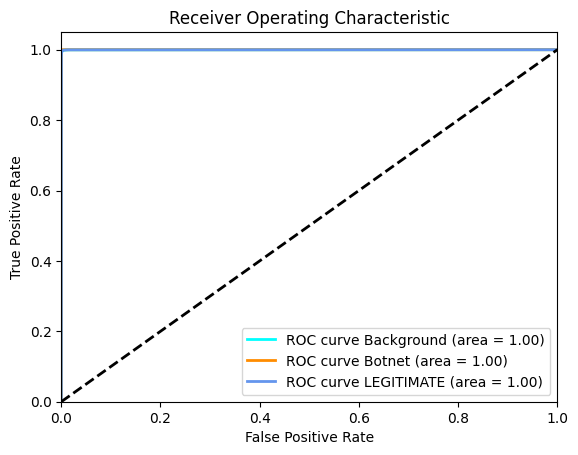

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

y_pred_proba = xgb_model.predict_proba(X_test)

#compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#plot all ROC curves
plt.figure()
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve {0} (area = {1:0.2f})'
             ''.format(categorical_mappings['label'][i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

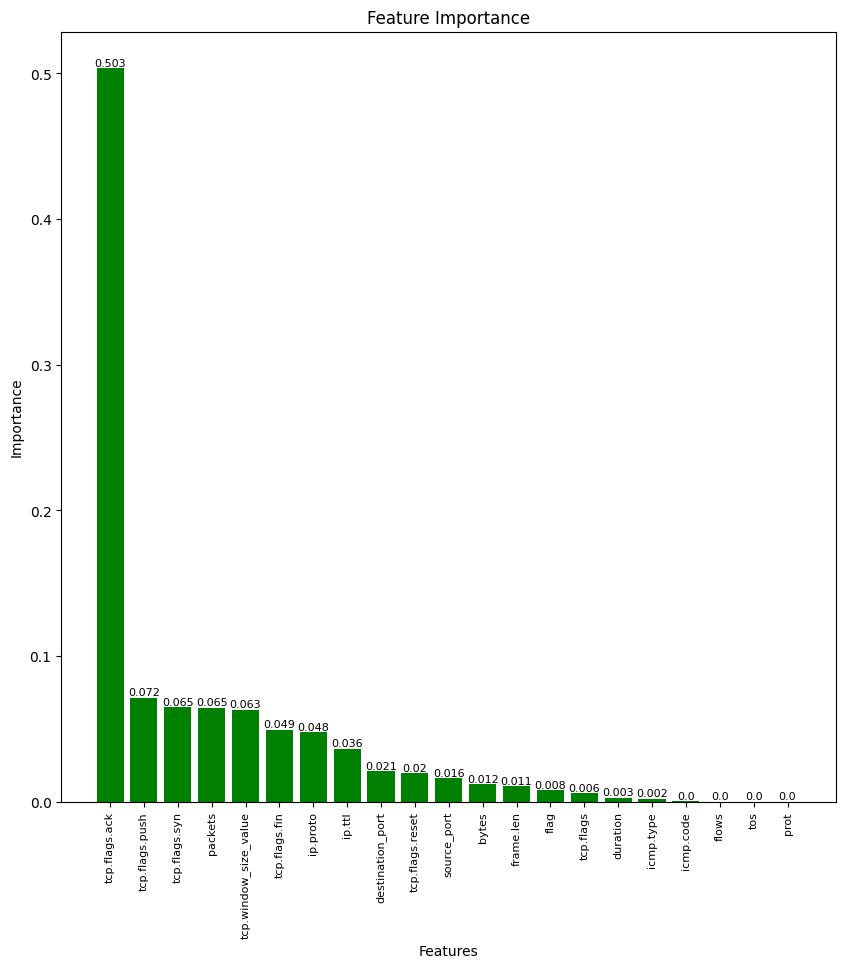

,feature,importance
0,tcp.flags.ack,0.503449
1,tcp.flags.push,0.071521
2,tcp.flags.syn,0.065065
3,packets,0.064528
4,tcp.window_size_value,0.063096
5,tcp.flags.fin,0.049492
6,ip.proto,0.047672
7,ip.ttl,0.036435
8,destination_port,0.021128
9,tcp.flags.reset,0.019747


"\nINTERPRETATIONS\nThe model learns that a high volume of traffic with the SYN flag but without a corresponding ACK is a very strong indicator of a SYN flood attack.\nThe presence or absence of the ACK flag becomes a critical feature for distinguishing legitimate traffic from this type of attack.\n\nThe TCP three-way handshake (SYN, SYN-ACK, ACK) is a fundamental part of how TCP connections are established.\nIn many types of DDoS attacks, particularly SYN floods, the attacker's goal is to overwhelm a server with connection requests.\nHow it's used in an attack: A botnet will send a massive number of SYN packets to the target server.\nThe server responds with SYN-ACK packets and waits for the final ACK to complete the handshake.\nHowever, the bots in the botnet never send the final ACK.\n\n"

In [ ]:
#feature importance
import matplotlib.pyplot as plt

#get feature importances
importances = xgb_model.feature_importances_

#sort features by importance
indices = np.argsort(importances)[::-1]

feature_names = X.columns[indices]
#visualize
plt.figure(figsize=(10, 10))
plt.bar(range(X.shape[1]), importances[indices], align='center', color='green')
#also show actual values on graph
for i, v in enumerate(importances[indices]):
    plt.text(i, v, str(round(v, 3)), ha='center', va='bottom', fontweight='light', fontsize=8)
plt.xticks(range(X.shape[1]), feature_names, rotation=90, fontsize=8)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Importance', fontsize=10)
plt.title('Feature Importance', fontsize=12)
plt.show()

#dataframe table
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances[indices]})
display(feature_importance_df)


"""
INTERPRETATIONS
The model learns that a high volume of traffic with the SYN flag but without a corresponding ACK is a very strong indicator of a SYN flood attack.
The presence or absence of the ACK flag becomes a critical feature for distinguishing legitimate traffic from this type of attack.

The TCP three-way handshake (SYN, SYN-ACK, ACK) is a fundamental part of how TCP connections are established.
In many types of DDoS attacks, particularly SYN floods, the attacker's goal is to overwhelm a server with connection requests.
How it's used in an attack: A botnet will send a massive number of SYN packets to the target server.
The server responds with SYN-ACK packets and waits for the final ACK to complete the handshake.
However, the bots in the botnet never send the final ACK.
"""